## Sagehen UZF1 Package Problem 1

This script reproduces example 1 in the UZF1 Techniques and Methods
(Niswonger et al., 2006).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
from pathlib import Path

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-sagehen"
try:
    root = Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else Path.cwd()
figs_path = root / "figures" if root else Path.cwd()
data_path = root / "data" / sim_name if root else Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlay = 1  # Number of layers in parent model
nrow = 73  # Number of rows in parent model
ncol = 81  # Number of columns in parent model
delr = 90.0  # Parent model column width ($m$)
delc = 90.0  # Parent model row width ($m$)
k11 = "0.005 - 0.3"  # Horizontal hydraulic conductivity ($m/d$)
k33 = "0.01 - 0.3"  # Vertical hydraulic conductivity ($m/d$)
sydum = "0.1 - 0.2"  # Specific Yield
dum1 = "0.15 - 0.25"  # Saturated water content
dum2 = 0.10  # Extinction water content
dum3 = "0.005 - 0.3"  # Saturated hydraulic conductivity of unsaturated zone
eps = 4.0  # Brooks-Corey Epsilon
sfrdum1 = 213  # Number of SFR stream reaches
sfrdum2 = 0.3  # Hydraulic conductivity of streambed ($m/d$)
sfrdum3 = 3  # Width of stream reaches ($m$)
sfrdum4 = 1  # Streambed thickness ($m$)

# Time related variables
num_ts = 399
perlen = [1] * num_ts
nper = len(perlen)
nstp = [1] * num_ts
tsmult = [1.0] * num_ts

# from mf-nwt .dis file
fname = "top1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:a93be6cf74bf376f696fc2fbcc316aea",
)
top = np.loadtxt(fpath)
fname = "bot1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:6503e01167875bd257479a2941d1d586",
)
bot1 = np.loadtxt(fpath)
# from mf-nwt .bas file
fname = "ibnd1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:7b33e2fba54eae694171c94c75e13d2e",
)
idomain1 = np.loadtxt(fpath)
fname = "strt1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:d49e24ec920472380787fd27c528123f",
)
strt = np.loadtxt(fpath)
# peel out locations of negative values for setting constant head data
tmp1 = np.where(idomain1 < 0)
listOfChdCoords = list(zip(np.zeros_like(tmp1[0]), tmp1[0], tmp1[1]))
# get the corresponding constant head values
if len(listOfChdCoords) > 0:
    chd_lay1 = list(np.take(strt, np.ravel_multi_index(tmp1, strt.shape)))
chdspd = []
for i in np.arange(len(listOfChdCoords)):
    chdspd.append([listOfChdCoords[i], chd_lay1[i]])
# finally, get rid of the negative values in idomain since mf6 treats
# negatives like zeros
idomain = np.abs(idomain1)

# from mf-nwt .upw file
fname = "kh1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:50c0a5bfd79b1c9d0e0900540c19d6cc",
)
k11 = np.loadtxt(fpath)
fname = "sy1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:6bc38fd082875633686732f34ba3e18b",
)
sy = np.loadtxt(fpath)
fname = "kv1.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:7b6685bf35f1150bef553f81c2dfb2cb",
)
k33 = np.loadtxt(fpath)
icelltype = 1  # Water table resides in layer 1
iconvert = np.ones_like(strt)

# Solver settings

nouter, ninner = 300, 500
hclose, rclose, relax = 3e-2, 3e-2, 0.97

# #### Prepping input for SFR package
# Get package_data information
orig_seg = [
    (1, 1, 9, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg1"),
    (2, 1, 10, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg2"),
    (3, 1, 9, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg3"),
    (4, 1, 11, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg4"),
    (5, 1, 15, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg5"),
    (6, 1, 13, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg6"),
    (7, 1, 12, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg7"),
    (8, 1, 14, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg8"),
    (9, 1, 10, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg9"),
    (10, 1, 11, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg10"),
    (11, 1, 12, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg11"),
    (12, 1, 13, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg12"),
    (13, 1, 14, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg13"),
    (14, 1, 15, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg14"),
    (15, 1, 0, 0, 0.00, 0.0, 0.0, 0, 0.04, "origSeg15"),
]

orig_rch = [
    (1, 45, 9, 1, 1),
    (1, 44, 9, 1, 2),
    (1, 43, 9, 1, 3),
    (1, 43, 10, 1, 4),
    (1, 42, 10, 1, 5),
    (1, 42, 11, 1, 6),
    (1, 42, 12, 1, 7),
    (1, 41, 12, 1, 8),
    (1, 41, 13, 1, 9),
    (1, 40, 13, 1, 10),
    (1, 40, 14, 1, 11),
    (1, 39, 14, 1, 12),
    (1, 39, 15, 1, 13),
    (1, 39, 16, 1, 14),
    (1, 39, 17, 1, 15),
    (1, 38, 17, 1, 16),
    (1, 38, 18, 1, 17),
    (1, 38, 19, 1, 18),
    (1, 38, 20, 1, 19),
    (1, 38, 21, 1, 20),
    (1, 38, 22, 1, 21),
    (1, 38, 23, 1, 22),
    (1, 37, 24, 1, 23),
    (1, 37, 25, 1, 24),
    (1, 36, 25, 1, 25),
    (1, 36, 26, 1, 26),
    (1, 35, 26, 1, 27),
    (1, 35, 27, 1, 28),
    (1, 36, 28, 1, 29),
    (1, 36, 29, 1, 30),
    (1, 36, 30, 1, 31),
    (1, 36, 31, 1, 32),
    (1, 36, 32, 1, 33),
    (1, 35, 32, 1, 34),
    (1, 35, 33, 1, 35),
    (1, 34, 33, 1, 36),
    (1, 34, 34, 1, 37),
    (1, 33, 34, 1, 38),
    (1, 33, 35, 1, 39),
    (1, 32, 35, 1, 40),
    (1, 32, 36, 1, 41),
    (1, 32, 37, 1, 42),
    (1, 53, 37, 2, 1),
    (1, 52, 37, 2, 2),
    (1, 52, 38, 2, 3),
    (1, 51, 38, 2, 4),
    (1, 50, 38, 2, 5),
    (1, 50, 39, 2, 6),
    (1, 49, 39, 2, 7),
    (1, 48, 39, 2, 8),
    (1, 47, 39, 2, 9),
    (1, 47, 40, 2, 10),
    (1, 46, 40, 2, 11),
    (1, 45, 40, 2, 12),
    (1, 45, 39, 2, 13),
    (1, 44, 39, 2, 14),
    (1, 43, 38, 2, 15),
    (1, 42, 38, 2, 16),
    (1, 41, 38, 2, 17),
    (1, 40, 38, 2, 18),
    (1, 40, 39, 2, 19),
    (1, 39, 39, 2, 20),
    (1, 38, 39, 2, 21),
    (1, 37, 40, 2, 22),
    (1, 36, 40, 2, 23),
    (1, 36, 41, 2, 24),
    (1, 35, 41, 2, 25),
    (1, 34, 41, 2, 26),
    (1, 33, 41, 2, 27),
    (1, 32, 41, 2, 28),
    (1, 31, 42, 2, 29),
    (1, 31, 33, 3, 1),
    (1, 31, 34, 3, 2),
    (1, 31, 35, 3, 3),
    (1, 31, 36, 3, 4),
    (1, 31, 37, 3, 5),
    (1, 48, 48, 4, 1),
    (1, 47, 48, 4, 2),
    (1, 46, 48, 4, 3),
    (1, 46, 47, 4, 4),
    (1, 45, 47, 4, 5),
    (1, 44, 47, 4, 6),
    (1, 43, 47, 4, 7),
    (1, 42, 47, 4, 8),
    (1, 41, 47, 4, 9),
    (1, 41, 48, 4, 10),
    (1, 40, 48, 4, 11),
    (1, 39, 48, 4, 12),
    (1, 38, 47, 4, 13),
    (1, 37, 47, 4, 14),
    (1, 36, 48, 4, 15),
    (1, 35, 48, 4, 16),
    (1, 35, 49, 4, 17),
    (1, 34, 49, 4, 18),
    (1, 34, 50, 4, 19),
    (1, 33, 50, 4, 20),
    (1, 55, 72, 5, 1),
    (1, 54, 72, 5, 2),
    (1, 53, 72, 5, 3),
    (1, 52, 72, 5, 4),
    (1, 51, 72, 5, 5),
    (1, 50, 73, 5, 6),
    (1, 49, 73, 5, 7),
    (1, 48, 73, 5, 8),
    (1, 48, 74, 5, 9),
    (1, 47, 74, 5, 10),
    (1, 46, 75, 5, 11),
    (1, 45, 75, 5, 12),
    (1, 45, 76, 5, 13),
    (1, 44, 76, 5, 14),
    (1, 45, 62, 6, 1),
    (1, 44, 62, 6, 2),
    (1, 43, 62, 6, 3),
    (1, 43, 63, 6, 4),
    (1, 42, 63, 6, 5),
    (1, 41, 63, 6, 6),
    (1, 40, 63, 6, 7),
    (1, 24, 55, 7, 1),
    (1, 25, 55, 7, 2),
    (1, 25, 56, 7, 3),
    (1, 26, 56, 7, 4),
    (1, 27, 56, 7, 5),
    (1, 28, 57, 7, 6),
    (1, 29, 57, 7, 7),
    (1, 30, 57, 7, 8),
    (1, 31, 57, 7, 9),
    (1, 32, 57, 7, 10),
    (1, 33, 57, 7, 11),
    (1, 33, 58, 7, 12),
    (1, 34, 58, 7, 13),
    (1, 34, 59, 7, 14),
    (1, 35, 59, 7, 15),
    (1, 36, 59, 7, 16),
    (1, 37, 60, 7, 17),
    (1, 23, 71, 8, 1),
    (1, 24, 71, 8, 2),
    (1, 25, 71, 8, 3),
    (1, 26, 71, 8, 4),
    (1, 27, 72, 8, 5),
    (1, 27, 73, 8, 6),
    (1, 28, 73, 8, 7),
    (1, 29, 73, 8, 8),
    (1, 30, 73, 8, 9),
    (1, 31, 73, 8, 10),
    (1, 32, 73, 8, 11),
    (1, 33, 73, 8, 12),
    (1, 34, 73, 8, 13),
    (1, 34, 74, 8, 14),
    (1, 35, 74, 8, 15),
    (1, 36, 74, 8, 16),
    (1, 36, 73, 8, 17),
    (1, 37, 73, 8, 18),
    (1, 38, 72, 8, 19),
    (1, 39, 72, 8, 20),
    (1, 40, 72, 8, 21),
    (1, 41, 72, 8, 22),
    (1, 42, 72, 8, 23),
    (1, 42, 73, 8, 24),
    (1, 31, 38, 9, 1),
    (1, 31, 39, 9, 2),
    (1, 31, 40, 9, 3),
    (1, 31, 41, 9, 4),
    (1, 31, 42, 9, 5),
    (1, 30, 42, 9, 6),
    (1, 30, 43, 10, 1),
    (1, 30, 44, 10, 2),
    (1, 29, 44, 10, 3),
    (1, 29, 45, 10, 4),
    (1, 29, 46, 10, 5),
    (1, 29, 47, 10, 6),
    (1, 30, 47, 10, 7),
    (1, 30, 48, 10, 8),
    (1, 31, 49, 10, 9),
    (1, 32, 50, 10, 10),
    (1, 32, 51, 11, 1),
    (1, 33, 52, 11, 2),
    (1, 33, 53, 11, 3),
    (1, 34, 53, 11, 4),
    (1, 34, 54, 11, 5),
    (1, 35, 54, 11, 6),
    (1, 35, 55, 11, 7),
    (1, 35, 56, 11, 8),
    (1, 36, 57, 11, 9),
    (1, 36, 58, 11, 10),
    (1, 36, 59, 11, 11),
    (1, 37, 59, 11, 12),
    (1, 37, 60, 11, 13),
    (1, 38, 60, 11, 14),
    (1, 38, 61, 12, 1),
    (1, 38, 62, 12, 2),
    (1, 38, 63, 12, 3),
    (1, 39, 63, 12, 4),
    (1, 39, 64, 13, 1),
    (1, 39, 65, 13, 2),
    (1, 40, 65, 13, 3),
    (1, 40, 66, 13, 4),
    (1, 40, 67, 13, 5),
    (1, 40, 68, 13, 6),
    (1, 41, 69, 13, 7),
    (1, 41, 70, 13, 8),
    (1, 42, 71, 13, 9),
    (1, 42, 72, 13, 10),
    (1, 42, 73, 13, 11),
    (1, 42, 73, 14, 1),
    (1, 43, 73, 14, 2),
    (1, 43, 74, 14, 3),
    (1, 43, 75, 14, 4),
    (1, 44, 75, 14, 5),
    (1, 44, 76, 14, 6),
    (1, 44, 77, 15, 1),
    (1, 44, 78, 15, 2),
    (1, 44, 79, 15, 3),
    (1, 45, 79, 15, 4),
]

# These are zero based
sfrcells = [
    (0, 44, 8),
    (0, 43, 8),
    (0, 42, 8),
    (0, 42, 9),
    (0, 41, 9),
    (0, 41, 10),
    (0, 41, 11),
    (0, 40, 11),
    (0, 40, 12),
    (0, 39, 12),
    (0, 39, 13),
    (0, 38, 13),
    (0, 38, 14),
    (0, 38, 15),
    (0, 38, 16),
    (0, 37, 16),
    (0, 37, 17),
    (0, 37, 18),
    (0, 37, 19),
    (0, 37, 20),
    (0, 37, 21),
    (0, 37, 22),
    (0, 36, 23),
    (0, 36, 24),
    (0, 35, 24),
    (0, 35, 25),
    (0, 34, 25),
    (0, 34, 26),
    (0, 35, 27),
    (0, 35, 28),
    (0, 35, 29),
    (0, 35, 30),
    (0, 35, 31),
    (0, 34, 31),
    (0, 34, 32),
    (0, 33, 32),
    (0, 33, 33),
    (0, 32, 33),
    (0, 32, 34),
    (0, 31, 34),
    (0, 31, 35),
    (0, 31, 36),
    (0, 52, 36),
    (0, 51, 36),
    (0, 51, 37),
    (0, 50, 37),
    (0, 49, 37),
    (0, 49, 38),
    (0, 48, 38),
    (0, 47, 38),
    (0, 46, 38),
    (0, 46, 39),
    (0, 45, 39),
    (0, 44, 39),
    (0, 44, 38),
    (0, 43, 38),
    (0, 42, 37),
    (0, 41, 37),
    (0, 40, 37),
    (0, 39, 37),
    (0, 39, 38),
    (0, 38, 38),
    (0, 37, 38),
    (0, 36, 39),
    (0, 35, 39),
    (0, 35, 40),
    (0, 34, 40),
    (0, 33, 40),
    (0, 32, 40),
    (0, 31, 40),
    (0, 30, 41),
    (0, 30, 32),
    (0, 30, 33),
    (0, 30, 34),
    (0, 30, 35),
    (0, 30, 36),
    (0, 47, 47),
    (0, 46, 47),
    (0, 45, 47),
    (0, 45, 46),
    (0, 44, 46),
    (0, 43, 46),
    (0, 42, 46),
    (0, 41, 46),
    (0, 40, 46),
    (0, 40, 47),
    (0, 39, 47),
    (0, 38, 47),
    (0, 37, 46),
    (0, 36, 46),
    (0, 35, 47),
    (0, 34, 47),
    (0, 34, 48),
    (0, 33, 48),
    (0, 33, 49),
    (0, 32, 49),
    (0, 54, 71),
    (0, 53, 71),
    (0, 52, 71),
    (0, 51, 71),
    (0, 50, 71),
    (0, 49, 72),
    (0, 48, 72),
    (0, 47, 72),
    (0, 47, 73),
    (0, 46, 73),
    (0, 45, 74),
    (0, 44, 74),
    (0, 44, 75),
    (0, 43, 75),
    (0, 44, 61),
    (0, 43, 61),
    (0, 42, 61),
    (0, 42, 62),
    (0, 41, 62),
    (0, 40, 62),
    (0, 39, 62),
    (0, 23, 54),
    (0, 24, 54),
    (0, 24, 55),
    (0, 25, 55),
    (0, 26, 55),
    (0, 27, 56),
    (0, 28, 56),
    (0, 29, 56),
    (0, 30, 56),
    (0, 31, 56),
    (0, 32, 56),
    (0, 32, 57),
    (0, 33, 57),
    (0, 33, 58),
    (0, 34, 58),
    (0, 35, 58),
    (0, 36, 59),
    (0, 22, 70),
    (0, 23, 70),
    (0, 24, 70),
    (0, 25, 70),
    (0, 26, 71),
    (0, 26, 72),
    (0, 27, 72),
    (0, 28, 72),
    (0, 29, 72),
    (0, 30, 72),
    (0, 31, 72),
    (0, 32, 72),
    (0, 33, 72),
    (0, 33, 73),
    (0, 34, 73),
    (0, 35, 73),
    (0, 35, 72),
    (0, 36, 72),
    (0, 37, 71),
    (0, 38, 71),
    (0, 39, 71),
    (0, 40, 71),
    (0, 41, 71),
    (0, 41, 72),
    (0, 30, 37),
    (0, 30, 38),
    (0, 30, 39),
    (0, 30, 40),
    (0, 30, 41),
    (0, 29, 41),
    (0, 29, 42),
    (0, 29, 43),
    (0, 28, 43),
    (0, 28, 44),
    (0, 28, 45),
    (0, 28, 46),
    (0, 29, 46),
    (0, 29, 47),
    (0, 30, 48),
    (0, 31, 49),
    (0, 31, 50),
    (0, 32, 51),
    (0, 32, 52),
    (0, 33, 52),
    (0, 33, 53),
    (0, 34, 53),
    (0, 34, 54),
    (0, 34, 55),
    (0, 35, 56),
    (0, 35, 57),
    (0, 35, 58),
    (0, 36, 58),
    (0, 36, 59),
    (0, 37, 59),
    (0, 37, 60),
    (0, 37, 61),
    (0, 37, 62),
    (0, 38, 62),
    (0, 38, 63),
    (0, 38, 64),
    (0, 39, 64),
    (0, 39, 65),
    (0, 39, 66),
    (0, 39, 67),
    (0, 40, 68),
    (0, 40, 69),
    (0, 41, 70),
    (0, 41, 71),
    (0, 41, 72),
    (0, 41, 72),
    (0, 42, 72),
    (0, 42, 73),
    (0, 42, 74),
    (0, 43, 74),
    (0, 43, 75),
    (0, 43, 76),
    (0, 43, 77),
    (0, 43, 78),
    (0, 44, 78),
]

rlen = [
    90.0,
    90.0,
    75.0,
    75.0,
    75.0,
    90.0,
    75.0,
    75.0,
    75.0,
    75.0,
    75.0,
    75.0,
    90.0,
    90.0,
    60.0,
    30.0,
    102.0,
    90.0,
    90.0,
    90.0,
    102.0,
    102.0,
    102.0,
    72.0,
    30.0,
    72.0,
    30.0,
    90.0,
    102.0,
    90.0,
    90.0,
    102.0,
    30.0,
    72.0,
    30.0,
    72.0,
    30.0,
    60.0,
    72.0,
    30.0,
    102.0,
    90.0,
    90.0,
    72.0,
    30.0,
    102.0,
    60.0,
    30.0,
    90.0,
    102.0,
    60.0,
    30.0,
    90.0,
    30.0,
    60.0,
    102.0,
    102.0,
    90.0,
    102.0,
    30.0,
    60.0,
    102.0,
    102.0,
    102.0,
    60.0,
    30.0,
    102.0,
    90.0,
    90.0,
    102.0,
    114.0,
    90.0,
    90.0,
    102.0,
    102.0,
    90.0,
    90.0,
    102.0,
    30.0,
    60.0,
    90.0,
    102.0,
    90.0,
    90.0,
    60.0,
    30.0,
    90.0,
    90.0,
    90.0,
    90.0,
    102.0,
    30.0,
    60.0,
    72.0,
    30.0,
    114.0,
    90.0,
    90.0,
    90.0,
    102.0,
    102.0,
    102.0,
    102.0,
    30.0,
    60.0,
    102.0,
    102.0,
    30.0,
    72.0,
    30.0,
    90.0,
    102.0,
    30.0,
    60.0,
    102.0,
    90.0,
    102.0,
    60.0,
    30.0,
    60.0,
    102.0,
    90.0,
    90.0,
    90.0,
    90.0,
    90.0,
    102.0,
    72.0,
    30.0,
    72.0,
    30.0,
    102.0,
    90.0,
    114.0,
    90.0,
    102.0,
    90.0,
    102.0,
    102.0,
    30.0,
    102.0,
    90.0,
    90.0,
    90.0,
    90.0,
    90.0,
    30.0,
    60.0,
    90.0,
    30.0,
    60.0,
    102.0,
    90.0,
    90.0,
    90.0,
    90.0,
    30.0,
    30.0,
    90.0,
    90.0,
    90.0,
    90.0,
    72.0,
    30.0,
    90.0,
    60.0,
    30.0,
    90.0,
    90.0,
    30.0,
    60.0,
    102.0,
    114.0,
    114.0,
    90.0,
    102.0,
    30.0,
    72.0,
    60.0,
    30.0,
    102.0,
    102.0,
    114.0,
    90.0,
    60.0,
    30.0,
    72.0,
    30.0,
    102.0,
    102.0,
    30.0,
    60.0,
    120.0,
    60.0,
    30.0,
    90.0,
    90.0,
    90.0,
    90.0,
    114.0,
    102.0,
    90.0,
    30.0,
    30.0,
    30.0,
    102.0,
    60.0,
    30.0,
    90.0,
    90.0,
    90.0,
    60.0,
    30.0,
]

rgrd = [
    0.150,
    0.120,
    0.180,
    0.160,
    0.130,
    0.111,
    0.047,
    0.060,
    0.040,
    0.100,
    0.227,
    0.090,
    0.042,
    0.064,
    0.083,
    0.081,
    0.062,
    0.065,
    0.089,
    0.097,
    0.141,
    0.186,
    0.217,
    0.203,
    0.206,
    0.206,
    0.144,
    0.147,
    0.135,
    0.129,
    0.124,
    0.136,
    0.162,
    0.147,
    0.157,
    0.147,
    0.115,
    0.117,
    0.111,
    0.120,
    0.099,
    0.073,
    0.037,
    0.038,
    0.060,
    0.048,
    0.024,
    0.029,
    0.032,
    0.028,
    0.024,
    0.029,
    0.033,
    0.038,
    0.032,
    0.038,
    0.051,
    0.047,
    0.037,
    0.063,
    0.063,
    0.049,
    0.069,
    0.077,
    0.063,
    0.045,
    0.037,
    0.043,
    0.048,
    0.054,
    0.065,
    0.067,
    0.091,
    0.091,
    0.071,
    0.073,
    0.021,
    0.031,
    0.045,
    0.033,
    0.029,
    0.042,
    0.075,
    0.103,
    0.092,
    0.095,
    0.087,
    0.083,
    0.094,
    0.102,
    0.093,
    0.081,
    0.099,
    0.077,
    0.057,
    0.056,
    0.044,
    0.050,
    0.075,
    0.076,
    0.074,
    0.074,
    0.071,
    0.072,
    0.056,
    0.060,
    0.048,
    0.043,
    0.049,
    0.039,
    0.042,
    0.056,
    0.081,
    0.071,
    0.068,
    0.068,
    0.068,
    0.044,
    0.078,
    0.071,
    0.051,
    0.054,
    0.056,
    0.056,
    0.050,
    0.048,
    0.038,
    0.022,
    0.049,
    0.059,
    0.043,
    0.043,
    0.045,
    0.049,
    0.042,
    0.031,
    0.016,
    0.010,
    0.012,
    0.015,
    0.012,
    0.011,
    0.022,
    0.044,
    0.056,
    0.060,
    0.114,
    0.100,
    0.067,
    0.086,
    0.127,
    0.141,
    0.118,
    0.100,
    0.083,
    0.087,
    0.100,
    0.067,
    0.056,
    0.083,
    0.100,
    0.076,
    0.045,
    0.020,
    0.053,
    0.042,
    0.038,
    0.047,
    0.047,
    0.057,
    0.040,
    0.032,
    0.045,
    0.053,
    0.042,
    0.049,
    0.094,
    0.085,
    0.036,
    0.027,
    0.030,
    0.033,
    0.024,
    0.017,
    0.025,
    0.021,
    0.015,
    0.010,
    0.010,
    0.012,
    0.018,
    0.022,
    0.017,
    0.019,
    0.010,
    0.013,
    0.022,
    0.017,
    0.021,
    0.043,
    0.044,
    0.038,
    0.050,
    0.033,
    0.021,
    0.020,
    0.024,
    0.029,
    0.020,
    0.011,
    0.024,
    0.033,
    0.022,
]

rtp = [
    2458.0,
    2449.0,
    2337.0,
    2416.0,
    2413.0,
    2397.0,
    2393.0,
    2390.0,
    2386.0,
    2384.0,
    2367.0,
    2360.0,
    2355.0,
    2351.0,
    2344.0,
    2341.0,
    2335.0,
    2331.0,
    2323.0,
    2315.0,
    2305.0,
    2287.0,
    2267.0,
    2246.0,
    2239.0,
    2225.0,
    2218.0,
    2209.0,
    2195.0,
    2183.0,
    2171.0,
    2160.0,
    2149.0,
    2141.0,
    2134.0,
    2125.0,
    2119.0,
    2114.0,
    2106.0,
    2101.0,
    2092.0,
    2085.0,
    2146.0,
    2143.0,
    2141.0,
    2136.0,
    2134.0,
    2133.0,
    2131.0,
    2128.0,
    2126.0,
    2125.0,
    2123.0,
    2121.0,
    2119.0,
    2117.0,
    2112.0,
    2107.0,
    2103.0,
    2101.0,
    2096.0,
    2093.0,
    2087.0,
    2079.0,
    2073.0,
    2071.0,
    2068.0,
    2065.0,
    2060.0,
    2056.0,
    2048.0,
    2115.0,
    2109.0,
    2098.0,
    2091.0,
    2084.0,
    2112.0,
    2110.0,
    2108.0,
    2106.0,
    2104.0,
    2101.0,
    2096.0,
    2087.0,
    2079.0,
    2076.0,
    2069.0,
    2063.0,
    2054.0,
    2046.0,
    2035.0,
    2031.0,
    2026.0,
    2020.0,
    2017.0,
    2013.0,
    2000.0,
    1996.0,
    1991.0,
    1982.0,
    1976.0,
    1967.0,
    1961.0,
    1955.0,
    1953.0,
    1948.0,
    1942.0,
    1940.0,
    1937.0,
    1935.0,
    2003.0,
    1999.0,
    1994.0,
    1990.0,
    1985.0,
    1978.0,
    1972.0,
    2032.0,
    2030.0,
    2025.0,
    2021.0,
    2016.0,
    2011.0,
    2006.0,
    2001.0,
    1997.0,
    1992.0,
    1990.0,
    1989.0,
    1985.0,
    1983.0,
    1980.0,
    1976.0,
    1971.0,
    2051.0,
    2047.0,
    2045.0,
    2044.0,
    2043.0,
    2042.0,
    2041.0,
    2040.0,
    2039.0,
    2036.0,
    2031.0,
    2026.0,
    2022.0,
    2014.0,
    2010.0,
    2005.0,
    2001.0,
    1989.0,
    1976.0,
    1967.0,
    1958.0,
    1952.0,
    1945.0,
    1943.0,
    2076.0,
    2071.0,
    2061.0,
    2053.0,
    2048.0,
    2047.0,
    2041.0,
    2037.0,
    2036.0,
    2033.0,
    2029.0,
    2026.0,
    2023.0,
    2021.0,
    2017.0,
    2011.0,
    2006.0,
    2002.0,
    1998.0,
    1991.0,
    1988.0,
    1987.0,
    1985.0,
    1982.0,
    1978.0,
    1977.0,
    1975.0,
    1974.0,
    1973.0,
    1972.0,
    1970.0,
    1969.0,
    1968.0,
    1967.0,
    1966.0,
    1965.0,
    1964.0,
    1963.0,
    1961.0,
    1959.0,
    1958.0,
    1955.0,
    1949.0,
    1946.0,
    1943.0,
    1942.0,
    1941.0,
    1940.0,
    1938.0,
    1937.0,
    1935.0,
    1934.0,
    1933.0,
    1930.0,
    1929.0,
]


def get_sfrsegs():
    return orig_seg


def get_sfrrchs():
    return orig_rch


def get_sfrcells():
    return sfrcells


def get_sfrlen():
    return rlen


def get_rgrd():
    return rgrd


def get_rtp():
    return rtp


segs = get_sfrsegs()
rchs = get_sfrrchs()
sfrcells = get_sfrcells()
rlen = get_sfrlen()
rgrd = get_rgrd()
rtp = get_rtp()

# Define some utility functions.


def gen_mf6_sfr_connections(orig_seg, orig_rch):
    """
    Defining a function that builds the new MF6 SFR connection information using
    original SFR input. This is a generalized function that can be used to
    convert MF2K5-based model to the new MF6 format.  Currently applied to the
    Sagehen and modsim models
    """
    conns = []
    for i in np.arange(0, len(orig_seg)):
        tup = orig_seg[i]
        segid = tup[0]
        ioutseg = tup[2]
        iupseg = tup[3]

        # Get all reaches associated with segment
        # Find an element in a list of tuples
        allrchs = [item for item in orig_rch if item[3] == segid]

        # Loop through allrchs and generate list of connections
        for rchx in allrchs:
            # rchx will be a tuple
            upconn = []
            dnconn = []

            if rchx[4] == 1:  # checks if first rch of segment
                # Collect all segs that dump to the current one (there may not
                # be any)
                dumpersegs = [item for item in orig_seg if item[2] == segid]
                # For every seg that outflows to current, set last reach of it
                # as an upstream connection
                for dumper in dumpersegs:
                    dumper_seg_id = dumper[0]
                    rch_cnt = len(
                        [item for item in orig_rch if item[3] == dumper_seg_id]
                    )
                    lastrch = [
                        item
                        for item in orig_rch
                        if item[3] == dumper_seg_id and item[4] == rch_cnt
                    ]
                    idx = orig_rch.index(lastrch[0])
                    upconn.append(int(idx))

                # Current reach is the most upstream reach for current segment
                if iupseg == 0:
                    pass
                elif iupseg > 0:  # Lake connections, signified with negative
                    # numbers, aren't handled here
                    iupseg_rchs = [item for item in orig_rch if item[3] == iupseg]
                    # Get the index of the last reach of the segment that was
                    # the upstream segment in the orig sfr file
                    idx = orig_rch.index(iupseg_rchs[len(iupseg_rchs) - 1])  #
                    upconn.append(idx)

                # Even if the first reach of a segment, it will have an outlet
                # either the next reach in the segment, or first reach of
                # outseg, which should be taken care of below
                if len(allrchs) > 1:
                    idx = orig_rch.index(rchx)
                    # adjust idx for 0-based and increment to next item in list
                    dnconn.append(int(idx + 1) * -1)

            elif rchx[4] > 1 and not rchx[4] == len(allrchs):
                # Current reach is 'interior' on the original segment and
                # therefore should only have 1 upstream & 1 downstream segment
                idx = orig_rch.index(rchx)
                # B/c 0-based, idx will already be incremented by -1
                upconn.append(int(idx - 1))
                # adjust idx for 0-based and increment to next item in list
                dnconn.append(int(idx + 1) * -1)  # all downstream connections
                # are negative in MF6

            if rchx[4] == len(allrchs):
                # If the last reach in a multi-reach segment, always need to
                # account for the reach immediately upstream (single reach segs
                # dealt with above), unless of course we're dealing with a
                # single reach segment like in the case of a spillway from a lk
                if len(allrchs) != 1:
                    idx = orig_rch.index(rchx)
                    # B/c 0-based, idx will already be incremented by -1
                    upconn.append(int(idx - 1))

                # Current reach is last reach in segment and may have multiple
                # downstream connections, particular when dealing with
                # diversions.
                if ioutseg == 0:
                    pass
                elif ioutseg > 0:  # Lake connections, signified with
                    # negative numbers, aren't handled here
                    idnseg_rchs = [
                        item for item in orig_rch if item[3] == ioutseg and item[4] == 1
                    ]
                    idx = orig_rch.index(idnseg_rchs[0])
                    # adjust idx for 0-based and increment to next item in list
                    dnconn.append(int(idx) * -1)

                # In addition to ioutseg, look for all segments that may have
                # the current segment as their iupseg
                possible_divs = [item for item in orig_seg if item[3] == rchx[3]]
                for segx in possible_divs:
                    # Next, peel out all first reach for any segments listed in
                    # possible_divs
                    first_rchs = [
                        item for item in orig_rch if item[3] == segx[0] and item[4] == 1
                    ]
                    for firstx in first_rchs:
                        idx = orig_rch.index(firstx)
                        # adjust idx for 0-based & increment to nxt itm in list
                        dnconn.append(int(idx) * -1)

            # Append the collection of upconn & dnconn as an entry in a list
            idx = orig_rch.index(rchx)
            # Adjust current index for 0-based
            conns.append([idx] + upconn + dnconn)

    return conns


def determine_runoff_conns_4mvr(elev_arr, ibnd, orig_rch, nrow, ncol):
    # Get the sfr information stored in a companion script
    sfr_dat = orig_rch.copy()
    sfrlayout = np.zeros_like(ibnd)
    for i, rchx in enumerate(sfr_dat):
        row = rchx[1]
        col = rchx[2]
        sfrlayout[row - 1, col - 1] = i + 1

    sfrlayout_new = sfrlayout.copy()

    stop_candidate = False

    for i in np.arange(0, nrow):
        for j in np.arange(0, ncol):
            # Check to ensure current cell is active
            if ibnd[i, j] == 0:
                continue

            # Check to make sure it is not a stream cell
            if not sfrlayout[i, j] == 0:
                continue

            # Recursively trace path by steepest decent back to a stream
            curr_i = i
            curr_j = j

            sfrlayout_conn_candidate_elev = 10000.0
            while True:
                direc = 0
                min_elev = elev_arr[curr_i, curr_j]

                # Look straight left
                if curr_j > 0:
                    if (
                        not sfrlayout[curr_i, curr_j - 1] == 0
                        and not ibnd[curr_i, curr_j - 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i, curr_j - 1] > 0 and (
                            elev_arr[curr_i, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i, curr_j - 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i, curr_j - 1]
                            sfrlayout_conn_candidate_elev = elev_arr[curr_i, curr_j - 1]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i, curr_j - 1] == 0
                        and not ibnd[curr_i, curr_j - 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i, curr_j - 1] < min_elev
                        ):
                            elevcm1 = elev_arr[curr_i, curr_j - 1]
                            min_elev = elevcm1
                            direc = 2

                # Look up and left
                if curr_j > 0 and curr_i > 0:
                    if (
                        not sfrlayout[curr_i - 1, curr_j - 1] == 0
                        and not ibnd[curr_i - 1, curr_j - 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i - 1, curr_j - 1] > 0 and (
                            elev_arr[curr_i - 1, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j - 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i - 1, curr_j - 1]
                            sfrlayout_conn_candidate_elev = elev_arr[
                                curr_i - 1, curr_j - 1
                            ]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i - 1, curr_j - 1] == 0
                        and not ibnd[curr_i - 1, curr_j - 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i - 1, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j - 1] < min_elev
                        ):
                            elevrm1cm1 = elev_arr[curr_i - 1, curr_j - 1]
                            min_elev = elevrm1cm1
                            direc = 5

                # Look straight right
                if curr_j < ncol - 1:
                    if (
                        not sfrlayout[curr_i, curr_j + 1] == 0
                        and not ibnd[curr_i, curr_j + 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i, curr_j + 1] > 0 and (
                            elev_arr[curr_i, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i, curr_j + 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i, curr_j + 1]
                            sfrlayout_conn_candidate_elev = elev_arr[curr_i, curr_j + 1]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i, curr_j + 1] == 0
                        and not ibnd[curr_i, curr_j + 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i, curr_j + 1] < min_elev
                        ):
                            elevcm1 = elev_arr[curr_i, curr_j + 1]
                            min_elev = elevcm1
                            direc = 4

                # Look straight right and down
                if curr_i < nrow - 1 and curr_j < ncol - 1:
                    if (
                        not sfrlayout[curr_i + 1, curr_j + 1] == 0
                        and not ibnd[curr_i + 1, curr_j + 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i + 1, curr_j + 1] > 0 and (
                            elev_arr[curr_i + 1, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j + 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i + 1, curr_j + 1]
                            sfrlayout_conn_candidate_elev = elev_arr[
                                curr_i + 1, curr_j + 1
                            ]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i + 1, curr_j + 1] == 0
                        and not ibnd[curr_i + 1, curr_j + 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i + 1, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j + 1] < min_elev
                        ):
                            elevrp1cp1 = elev_arr[curr_i + 1, curr_j + 1]
                            min_elev = elevrp1cp1
                            direc = 7

                # Look straight up
                if curr_i > 0:
                    if (
                        not sfrlayout[curr_i - 1, curr_j] == 0
                        and not ibnd[curr_i - 1, curr_j] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i - 1, curr_j] > 0 and (
                            elev_arr[curr_i - 1, curr_j] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i - 1, curr_j]
                            sfrlayout_conn_candidate_elev = elev_arr[curr_i - 1, curr_j]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i - 1, curr_j] == 0
                        and not ibnd[curr_i - 1, curr_j] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i - 1, curr_j] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j] < min_elev
                        ):
                            elevcm1 = elev_arr[curr_i - 1, curr_j]
                            min_elev = elevcm1
                            direc = 3

                # Look up and right
                if curr_i > 0 and curr_j < ncol - 1:
                    if (
                        not sfrlayout[curr_i - 1, curr_j + 1] == 0
                        and not ibnd[curr_i - 1, curr_j + 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i - 1, curr_j + 1] > 0 and (
                            elev_arr[curr_i - 1, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j + 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i - 1, curr_j + 1]
                            sfrlayout_conn_candidate_elev = elev_arr[
                                curr_i - 1, curr_j + 1
                            ]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i - 1, curr_j + 1] == 0
                        and not ibnd[curr_i - 1, curr_j + 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i - 1, curr_j + 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i - 1, curr_j + 1] < min_elev
                        ):
                            elevrm1cp1 = elev_arr[curr_i - 1, curr_j + 1]
                            min_elev = elevrm1cp1
                            direc = 6

                # Look straight down
                if curr_i < nrow - 1:
                    if (
                        not sfrlayout[curr_i + 1, curr_j] == 0
                        and not ibnd[curr_i + 1, curr_j] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i + 1, curr_j] > 0 and (
                            elev_arr[curr_i + 1, curr_j] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i + 1, curr_j]
                            sfrlayout_conn_candidate_elev = elev_arr[curr_i + 1, curr_j]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i + 1, curr_j] == 0
                        and not ibnd[curr_i + 1, curr_j] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i + 1, curr_j] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j] < min_elev
                        ):
                            elevrp1 = elev_arr[curr_i + 1, curr_j]
                            min_elev = elevrp1
                            direc = 1

                # Look down and left
                if curr_i < nrow - 1 and curr_j > 0:
                    if (
                        not sfrlayout[curr_i + 1, curr_j - 1] == 0
                        and not ibnd[curr_i + 1, curr_j - 1] == 0
                    ):  # Step in if neighbor is a stream cell
                        if elev_arr[curr_i + 1, curr_j - 1] > 0 and (
                            elev_arr[curr_i + 1, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j - 1]
                            < sfrlayout_conn_candidate_elev
                        ):
                            sfrlayout_conn_candidate = sfrlayout[curr_i + 1, curr_j - 1]
                            sfrlayout_conn_candidate_elev = elev_arr[
                                curr_i + 1, curr_j - 1
                            ]
                            stop_candidate = True

                    elif (
                        not elev_arr[curr_i + 1, curr_j - 1] == 0
                        and not ibnd[curr_i + 1, curr_j - 1] == 0
                    ):  # Step here if neighbor is not an sfr cell
                        if (
                            elev_arr[curr_i + 1, curr_j - 1] < elev_arr[curr_i, curr_j]
                            and elev_arr[curr_i + 1, curr_j - 1] < min_elev
                        ):
                            elevrp1cm1 = elev_arr[curr_i + 1, curr_j - 1]
                            min_elev = elevrp1cm1
                            direc = 8

                # if stop candidate found, don't move the cell indices
                if not stop_candidate:
                    # Direc corresponds to:
                    #  |----------------------
                    #  |  5  |    3    |  6  |
                    #  |----------------------
                    #  |  2  | cur_cel |  4  |
                    #  |----------------------
                    #  |  8  |    1    |  7  |
                    #  |----------------------
                    if direc == 0:
                        break
                    elif direc == 1:
                        curr_i += 1
                    elif direc == 2:
                        curr_j -= 1
                    elif direc == 3:
                        curr_i -= 1
                    elif direc == 4:
                        curr_j += 1
                    elif direc == 5:
                        curr_i -= 1
                        curr_j -= 1
                    elif direc == 6:
                        curr_i -= 1
                        curr_j += 1
                    elif direc == 7:
                        curr_i += 1
                        curr_j += 1
                    elif direc == 8:
                        curr_i += 1
                        curr_j -= 1

                if stop_candidate:
                    sfrlayout_new[i, j] = sfrlayout_conn_candidate
                    stop_candidate = False
                    break  # Bust out of while loop
                elif not stop_candidate:
                    # Check if encountered ibnd == 0, which may be a lake or
                    # boundary that drains out of model
                    if ibnd[curr_i, curr_j] == 0:
                        # This condition is dealt with after looping through
                        # all cells, see comment "Last step is set..."
                        break
                    pass  # Commence next downstream cell search

    # Last step is set the 0's in the vicinity of the lake equal to the
    # negative of the lake connection
    for i in np.arange(0, nrow):
        for j in np.arange(0, ncol):
            if sfrlayout_new[i, j] == 0 and ibnd[i, j] > 0:
                sfrlayout_new[i, j] = -1

    return sfrlayout_new


# Define the connections
conns = gen_mf6_sfr_connections(segs, rchs)

rwid = 3.0
rbth = 1.0
rhk = 0.6
man = 0.04
ustrf = 1.0
ndv = 0
pkdat = []
for i in np.arange(len(rlen)):
    ncon = len(conns[i]) - 1
    pkdat.append(
        (
            i,
            sfrcells[i],
            rlen[i],
            rwid,
            rgrd[i],
            rtp[i],
            rbth,
            rhk,
            man,
            ncon,
            ustrf,
            ndv,
        )
    )

# Instantiating MODFLOW 6 drain package
# Here, the drain (DRN) package is used to simulate groundwater discharge to
# land surface to keep this water separate from rejected infiltrated simulated
# by the UZF package. Need to cycle through all land surface cells and create a
# drain for handling groundwater discharge to land surface
drn_spd = []
drn_dict = {}
drn_dict_rev = {}
# Use an arbitrarily high conductance term to avoid impeding groundwater disch.
cond = 10000
# See definition of auxdepthname in DRN package doc to learn more about param
ddrn = -0.25
idrnno = 0
for i in np.arange(0, top.shape[0]):
    for j in np.arange(0, top.shape[1]):
        # Don't add drains to sfr and chd cells:
        sfrCell_bool = (
            1
            if len([itm for itm in sfrcells if itm[1] == i and itm[2] == j]) > 0
            else 0
        )
        chdCell_bool = (
            1
            if len([itm for itm in listOfChdCoords if itm[1] == i and itm[2] == j]) > 0
            else 0
        )
        if idomain1[i, j] and not sfrCell_bool and not chdCell_bool:
            drn_spd.append([(0, i, j), top[i, j], cond, ddrn])  #  'ddrn',
            # append dictionary of drain indices
            drn_dict.update({(i, j): idrnno})
            drn_dict_rev.update({idrnno: (i, j)})
            idrnno += 1


# Prepping input for UZF package
fname = "iuzbnd.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:280faee0782e0de5f2046b38ac20c271",
)
iuzbnd = np.loadtxt(fpath)
fname = "thts.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:6ebb033605c7e4700ddcf3f2e51ac371",
)
thts = np.loadtxt(fpath)
fname = "vks.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:61892e6cff6dae1879112c9eb03a1614",
)
uzk33 = np.loadtxt(fpath)
fname = "finf_gradient.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:e5ac0a0b27a66dd9f2eff63a63c6e6fe",
)
finf_grad = np.loadtxt(fpath)
# next, load time series of multipliers
fname = "uzf_ts.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-ORG/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:969ed0391d64804ec8395a578eb08ed1",
)
uz_ts = pd.read_csv(fpath, delim_whitespace=True, header=0)

# Need to set iuzbnd inactive where there are constant head cells, or where the
# model grid is inactive
cells2inactivate = idomain1 - iuzbnd
iuzbnd = iuzbnd + cells2inactivate
for chd_cell in listOfChdCoords:
    iuzbnd[chd_cell[1], chd_cell[2]] = 0

ha = 0.0
hroot = 0.0
rootact = 0.0

uzf_packagedata = []
pd0 = []
iuzno_cell_dict = {}
iuzno_dict_rev = {}
iuzno = 0
surfdep = 0.1
# Set up the UZF static variables
nuzfcells = 0
for k in range(nlay):
    for i in range(0, iuzbnd.shape[0] - 1):
        for j in range(0, iuzbnd.shape[1] - 1):
            if iuzbnd[i, j] != 0:
                nuzfcells += 1
                if k == 0:
                    lflag = 1
                    # establish new dictionary entry for current cell
                    # addresses & iuzno connections are both 0-based
                    iuzno_cell_dict.update({(i, j): iuzno})
                    # For post-processing the mvr output, need reverse dict
                    iuzno_dict_rev.update({iuzno: (i, j)})
                else:
                    lflag = 0

                # Set the vertical connection, which is the cell below,
                # but in this 1 layer model set to -1 which flopy adjusts to 0
                ivertcon = -1

                vks = uzk33[i, j]
                thtr = uz_ts["extwc"].iloc[0]
                thtsx = thts[i, j]
                thti = thtr + 0.01
                eps = 4.0

                # Set the boundname for the land surface cells
                bndnm = "sage"

                uz = [
                    iuzno,
                    (k, i, j),
                    lflag,
                    ivertcon,
                    surfdep,
                    vks,
                    thtr,
                    thtsx,
                    thti,
                    eps,
                    bndnm,
                ]
                uzf_packagedata.append(uz)

                iuzno += 1

# Next prepare the stress period data for UZF
# Store the steady state uzf stresses in dictionary
uzf_perioddata = {}
for t in range(num_ts):
    iuzno = 0
    spdx = []
    for i in range(0, iuzbnd.shape[0] - 1):
        for j in range(0, iuzbnd.shape[1] - 1):
            if iuzbnd[i, j] != 0:
                finf = finf_grad[i, j] * uz_ts["finf"].iloc[t]
                pet = uz_ts["pet"].iloc[t]
                extdp = uz_ts["rootdepth"].iloc[t]
                extwc = uz_ts["extwc"].iloc[t]
                spdx.append([iuzno, finf, pet, extdp, extwc, ha, hroot, rootact])
                iuzno += 1
    uzf_perioddata.update({t: spdx})

# Set up runoff connections, which relies on a helper function inside a
# companion script
#
# Leverages a function that uses the top elevation array and SFR locations to
# calculate an array that is the equivalent of the irunbnd array from the UZF1
# package.  The MVR package will be used to establish these connection in MF6
# since the IRUNBND functionality went away in the new MF6 framework.
irunbnd = determine_runoff_conns_4mvr(top, idomain1, rchs, nrow, ncol)
iuzno = 0
k = 0  # Hard-wire the layer no.
first0ok = True
static_mvrperioddata = []
for i in range(0, iuzbnd.shape[0]):
    for j in range(0, iuzbnd.shape[1]):
        if irunbnd[i, j] > 0:  # This is a uzf -> sfr connection
            iuzno = iuzno_cell_dict.get((i, j))
            if iuzno or first0ok:
                static_mvrperioddata.append(
                    ("UZF-1", iuzno, "SFR-1", irunbnd[i, j] - 1, "FACTOR", 1.0)
                )

        drn_idx = drn_dict.get((i, j))
        if drn_idx:
            static_mvrperioddata.append(
                ("DRN-1", drn_idx, "SFR-1", irunbnd[i, j] - 1, "FACTOR", 1.0)
            )
            first0ok = False

mvrspd = {0: static_mvrperioddata}
mvrpack = [["UZF-1"], ["SFR-1"], ["DRN-1"]]
maxpackages = len(mvrpack)
maxmvr = 10000  # Something arbitrarily high

# ### Model setup
#
# Define functions to build models, write input files, and run the simulation.

/tmp/ipykernel_12523/574447674.py:1780: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  uz_ts = pd.read_csv(fpath, delim_whitespace=True, header=0)


In [3]:
def build_models(silent=False):
    # Instantiate the MODFLOW 6 simulation
    sim_ws = workspace / sim_name
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name,
        version="mf6",
        sim_ws=sim_ws,
        exe_name="mf6",
    )

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    for i in range(len(perlen)):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwfname = sim_name
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        newtonoptions="newton",
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        inner_dvclose=hclose,
        rcloserecord="1000.0 strict",
        inner_maximum=ninner,
        relaxation_factor=relax,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=bot1,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        alternative_cell_averaging="AMT-HMK",
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=False,
        filename=f"{gwfname}.npf",
    )

    # Instantiate MODFLOW 6 storage package
    flopy.mf6.ModflowGwfsto(
        gwf,
        ss=2e-6,
        sy=sy,
        iconvert=iconvert,
        steady_state={0: True},
        transient={1: True},
        filename=f"{gwfname}.sto",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=f"{gwfname}.bud",
        head_filerecord=f"{gwfname}.hds",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    # Instantiating MODFLOW 6 constant head package
    chdspdx = {0: chdspd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspdx,
        save_flows=False,
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    maxbound = len(drn_spd)  # The total number
    spd = {0: drn_spd}
    flopy.mf6.ModflowGwfdrn(
        gwf,
        pname="DRN-1",
        auxiliary=["ddrn"],
        auxdepthname="ddrn",
        print_input=False,
        print_flows=False,
        maxbound=maxbound,
        mover=True,
        stress_period_data=spd,  # wel_spd established in the MVR setup
        boundnames=False,
        save_flows=True,
        filename=f"{gwfname}.drn",
    )

    # Instantiating MODFLOW 6 streamflow routing package
    flopy.mf6.ModflowGwfsfr(
        gwf,
        print_stage=False,
        print_flows=False,
        budget_filerecord=gwfname + ".sfr.bud",
        save_flows=True,
        mover=True,
        pname="SFR-1",
        time_conversion=86400.0,
        boundnames=True,
        nreaches=len(conns),
        packagedata=pkdat,
        connectiondata=conns,
        perioddata=None,
        filename=f"{gwfname}.sfr",
    )

    # Instantiating MODFLOW 6 unsaturated zone flow package
    flopy.mf6.ModflowGwfuzf(
        gwf,
        nuzfcells=nuzfcells,
        boundnames=True,
        mover=True,
        ntrailwaves=15,
        nwavesets=150,
        print_flows=False,
        save_flows=True,
        simulate_et=True,
        linear_gwet=True,
        packagedata=uzf_packagedata,
        perioddata=uzf_perioddata,
        budget_filerecord=f"{gwfname}.uzf.bud",
        pname="UZF-1",
        filename=f"{gwfname}.uzf",
    )

    flopy.mf6.ModflowGwfmvr(
        gwf,
        pname="MVR-1",
        maxmvr=maxmvr,
        print_flows=False,
        maxpackages=maxpackages,
        packages=mvrpack,
        perioddata=mvrspd,
        budget_filerecord=gwfname + ".mvr.bud",
        filename=f"{gwfname}.mvr",
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 6)
figure_size_ts = (6, 3)


def plot_results(mf6):
    with styles.USGSPlot():
        # Generate a plot of FINF distribution
        finf_plt = finf_grad.copy()
        finf_plt[idomain1 == 0] = np.nan

        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(finf_plt, cmap="jet")
        title = "Precipitation distribution"
        cbar = plt.colorbar(shrink=0.5)
        cbar.ax.set_title("Infiltration\nrate\nfactor", pad=20)
        plt.xlabel("Column Number")
        plt.ylabel("Row Number")
        styles.heading(heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-finfFact.png"
            fig.savefig(fpth)

        # Start by retrieving some output
        gwf = mf6.get_model(next(iter(mf6.model_names)))
        hdsobj = gwf.output.head()
        modobj = gwf.output.budget()
        sfrobj = gwf.sfr.output.budget()
        uzfobj = gwf.uzf.output.budget()

        ckstpkper = modobj.get_kstpkper()

        hds = []
        depths = []
        hd_tmp = hdsobj.get_data(kstpkper=ckstpkper[0])
        hd_tmp = np.where(hd_tmp == 1e30, 0, hd_tmp)
        hds.append(hd_tmp)
        depths.append(top - hd_tmp[0, :, :])
        depths = np.array(depths)
        depths = depths[0, :, :]

        # Generate a plot of the gw table depths for the steady state stress per
        depths[idomain1 == 0] = np.nan

        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(depths, vmin=0, vmax=25, cmap="jet")
        cbar = plt.colorbar(shrink=0.5, ticks=[0, 5, 10, 15, 20, 25])
        cbar.ax.set_yticklabels(["0", "5", "10", "15", "20", "> 25"])
        cbar.ax.set_title("Depth to\nwater\ntable,\nin m", pad=20)
        plt.xlabel("Column Number")
        plt.ylabel("Row Number")
        title = "Depth To Groundwater"
        styles.heading(heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-gwDepth.png"
            fig.savefig(fpth)

        drn_disQ = []
        uzrech = []
        finf_tot = []
        sfr_gwsw = []
        sfr_flow = []
        rejinf = []
        uzet = []
        gwet = []
        outflow = []

        for kstpkper in ckstpkper:
            # 1. Compile groundwater discharge to land surface
            drn_tmp = modobj.get_data(kstpkper=kstpkper, text="      DRN-TO-MVR")
            drn_arr = np.zeros_like(top)
            for itm in drn_tmp[0]:
                i, j = drn_dict_rev[itm[1] - 1]
                drn_arr[i, j] = itm[2]
            drn_disQ.append(drn_arr)

            # 2. Compile groundwater discharge to stream cells
            sfr_tmp = sfrobj.get_data(kstpkper=kstpkper, text="             GWF")
            sfr_arr = np.zeros_like(top)
            for x, itm in enumerate(sfr_tmp[0]):
                i = sfrcells[x][1]
                j = sfrcells[x][2]
                sfr_arr[i, j] = itm[2]
            sfr_gwsw.append(sfr_arr)

            # 3. Compile Infiltrated amount
            uzf_tmp = uzfobj.get_data(kstpkper=kstpkper, text="    INFILTRATION")
            finf_arr = np.zeros_like(top)
            for itm in uzf_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                finf_arr[i, j] = itm[2]
            finf_tot.append(finf_arr)

            # 4. Compile recharge from UZF
            uzrch_tmp = uzfobj.get_data(kstpkper=kstpkper, text="             GWF")
            uzrch_arr = np.zeros_like(top)
            for itm in uzrch_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                uzrch_arr[i, j] = itm[2]
            uzrech.append(uzrch_arr)

            # 5. Compile rejected infiltration
            rejinf_tmp = uzfobj.get_data(kstpkper=kstpkper, text="  REJ-INF-TO-MVR")
            rejinf_arr = np.zeros_like(top)
            for itm in rejinf_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                rejinf_arr[i, j] = itm[2]
            rejinf.append(rejinf_arr)

            # 6. Compile unsat ET
            uzet_tmp = uzfobj.get_data(kstpkper=kstpkper, text="            UZET")
            uzet_arr = np.zeros_like(top)
            for itm in uzet_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                uzet_arr[i, j] = itm[2]
            uzet.append(uzet_arr)

            # 7. Compile groundwater ET
            gwet_tmp = modobj.get_data(kstpkper=kstpkper, text="        UZF-GWET")
            gwet_arr = np.zeros_like(top)
            for itm in gwet_tmp[0]:
                i, j = iuzno_dict_rev[itm[1] - 1]
                gwet_arr[i, j] = itm[2]
            gwet.append(gwet_arr)

            # 8. Get flows at outlet
            outletQ = sfrobj.get_data(kstpkper=kstpkper, text="    FLOW-JA-FACE")
            outflow.append(outletQ[0][-1][2])

        drn_disQ = np.array(drn_disQ)
        sfr_gwsw = np.array(sfr_gwsw)
        finf_tot = np.array(finf_tot)
        uzrech = np.array(uzrech)
        rejinf = np.array(rejinf)
        uzet = np.array(uzet)
        gwet = np.array(gwet)
        outflow = np.array(outflow)

        drn_disQ_ts = drn_disQ.sum(axis=-1).sum(axis=-1)
        sfr_gwsw_ts = sfr_gwsw.sum(axis=-1).sum(axis=-1)
        finf_tot_ts = finf_tot.sum(axis=-1).sum(axis=-1)
        uzrech_ts = uzrech.sum(axis=-1).sum(axis=-1)
        rejinf_ts = rejinf.sum(axis=-1).sum(axis=-1)
        uzet_ts = uzet.sum(axis=-1).sum(axis=-1)
        gwet_ts = gwet.sum(axis=-1).sum(axis=-1)

        rng = pd.date_range(start="11/1/1999", end="10/31/2000", freq="D")
        data = {
            "Recharge": abs(uzrech_ts[0:366]),
            "Infiltration": abs(finf_tot_ts[0:366]),
            "GroundwaterET": abs(gwet_ts[0:366]),
            "UnsaturatedZoneET": abs(uzet_ts[0:366]),
        }
        vals1 = pd.DataFrame(data, index=rng)

        fig = plt.figure(figsize=figure_size_ts, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        vals1.Infiltration.plot(style="k-", linewidth=0.3)
        vals1.Recharge.plot(style="b-", linewidth=0.7)
        vals1.GroundwaterET.plot(
            style="-", color="darkgreen", linewidth=0.7, label="Groundwater ET"
        )
        vals1.UnsaturatedZoneET.plot(
            style="-", color="orange", linewidth=1, label="Unsaturated Zone ET"
        )
        ax.set_ylim(0, 700000)
        plt.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=True,
        )  # labels along the bottom edge are off
        ax.set_xlabel("Month")
        ax.set_ylabel("Volumetric Rate, $m^3$ per day")
        styles.graph_legend(ax)
        title = "Unsaturated Zone Flow Budget"
        styles.heading(heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-uzFlow.png"
            fig.savefig(fpth)

        data_sfr = {
            "GroundwaterDischarge": abs(drn_disQ_ts[0:366]),
            "RejectedInfiltration": abs(rejinf_ts[0:366]),
            "gwswExchange": abs(sfr_gwsw_ts[0:366]),
            "outflow": outflow[0:366],
        }
        vals2 = pd.DataFrame(data_sfr, index=rng)

        fig = plt.figure(figsize=figure_size_ts, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        vals2.outflow.plot(
            style="-", linewidth=0.5, color="royalblue", label="Streamflow at Outlet"
        )
        vals2.GroundwaterDischarge.plot(
            style="k-", linewidth=0.7, label="Groundwater Discharge"
        )
        vals2.RejectedInfiltration.plot(
            style="-", linewidth=0.7, color="brown", label="Rejected Infiltration"
        )
        vals2.gwswExchange.plot(
            style="-", color="darkgreen", linewidth=0.7, label="GW Discharge to Streams"
        )
        ax.set_ylim(0, 350000)
        plt.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=True,
        )  # labels along the bottom edge are off
        ax.set_xlabel("Month")
        ax.set_ylabel("Volumetric Rate, $m^3$ per day")
        styles.graph_legend(ax)
        title = "Surface Water Flow"
        styles.heading(heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{mf6.name}-swFlow.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 130942.54 ms


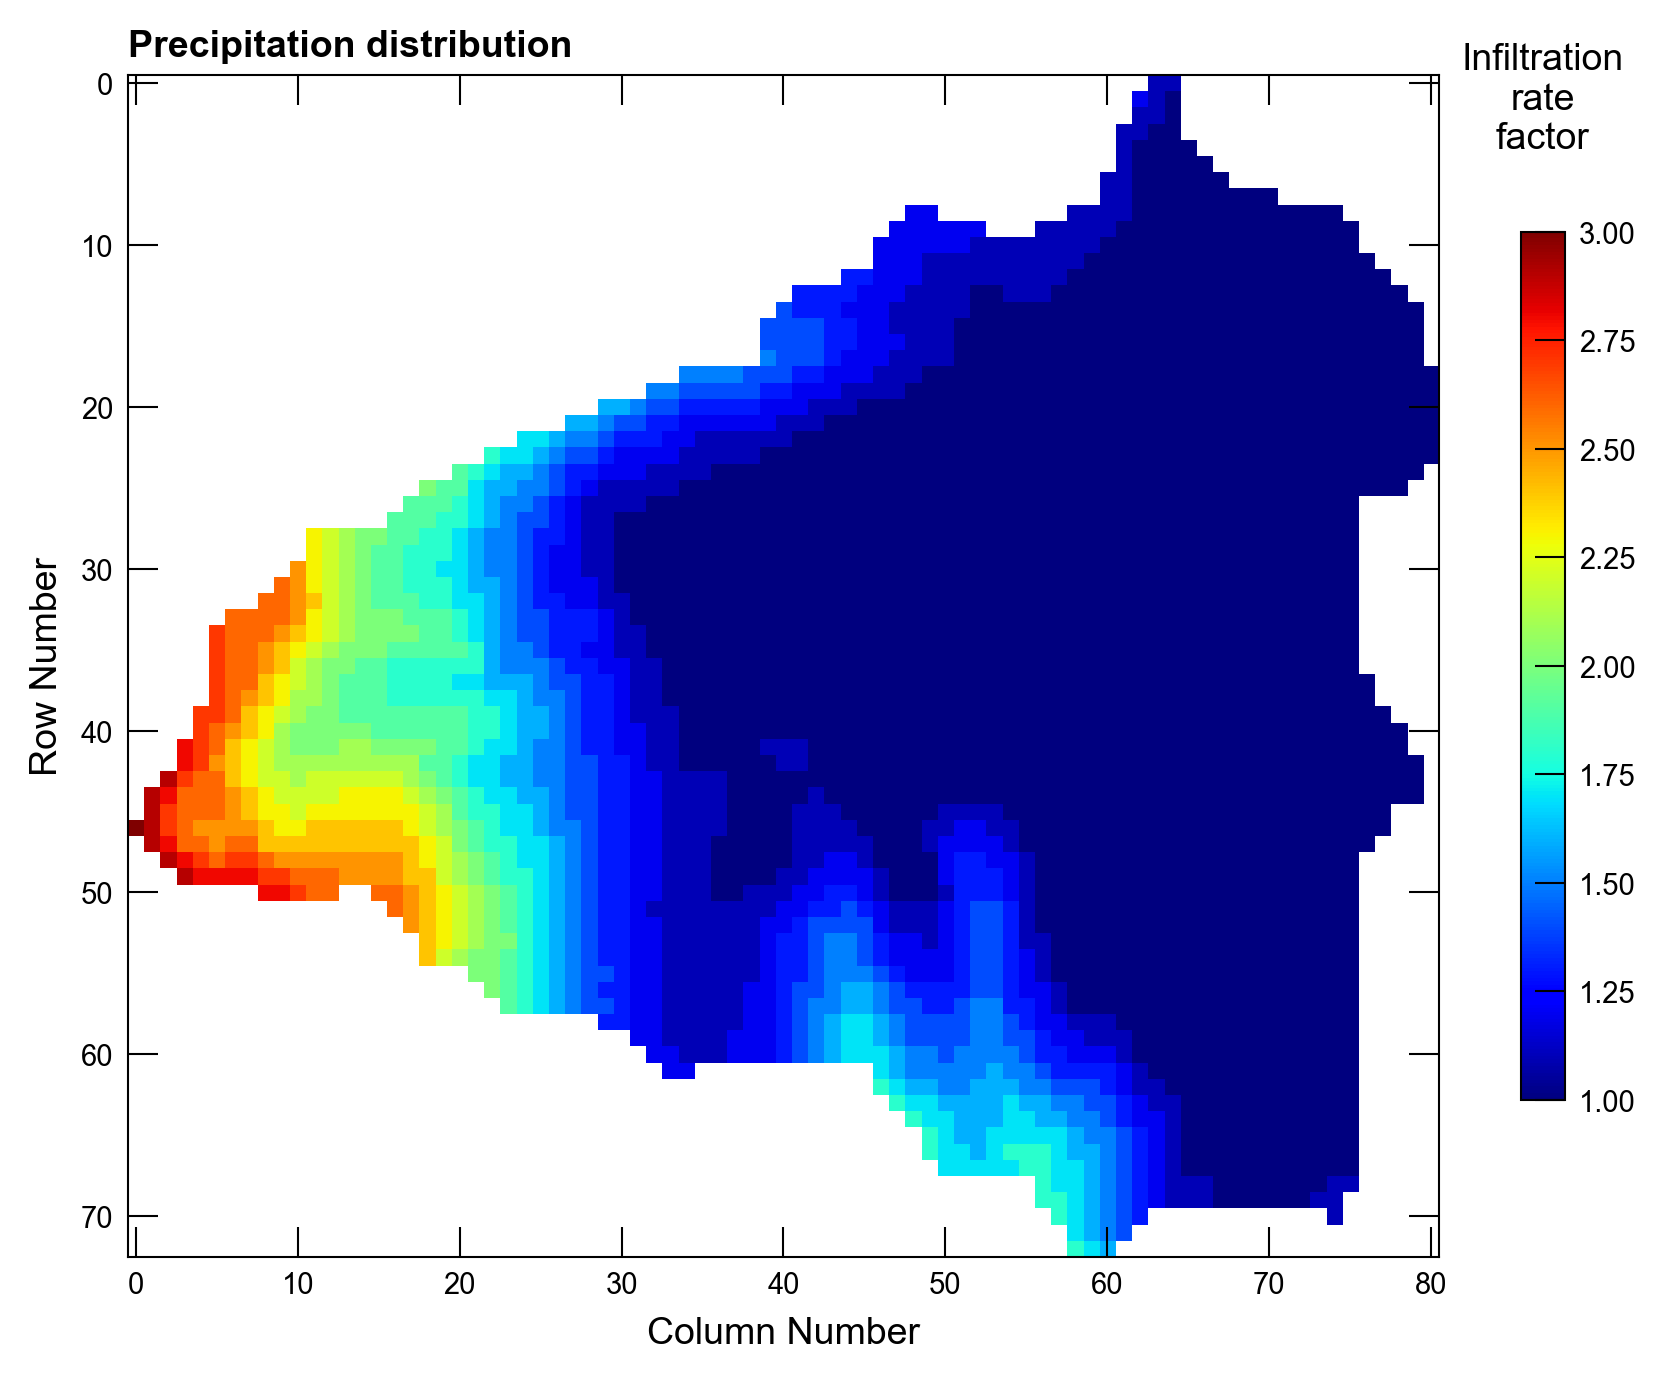

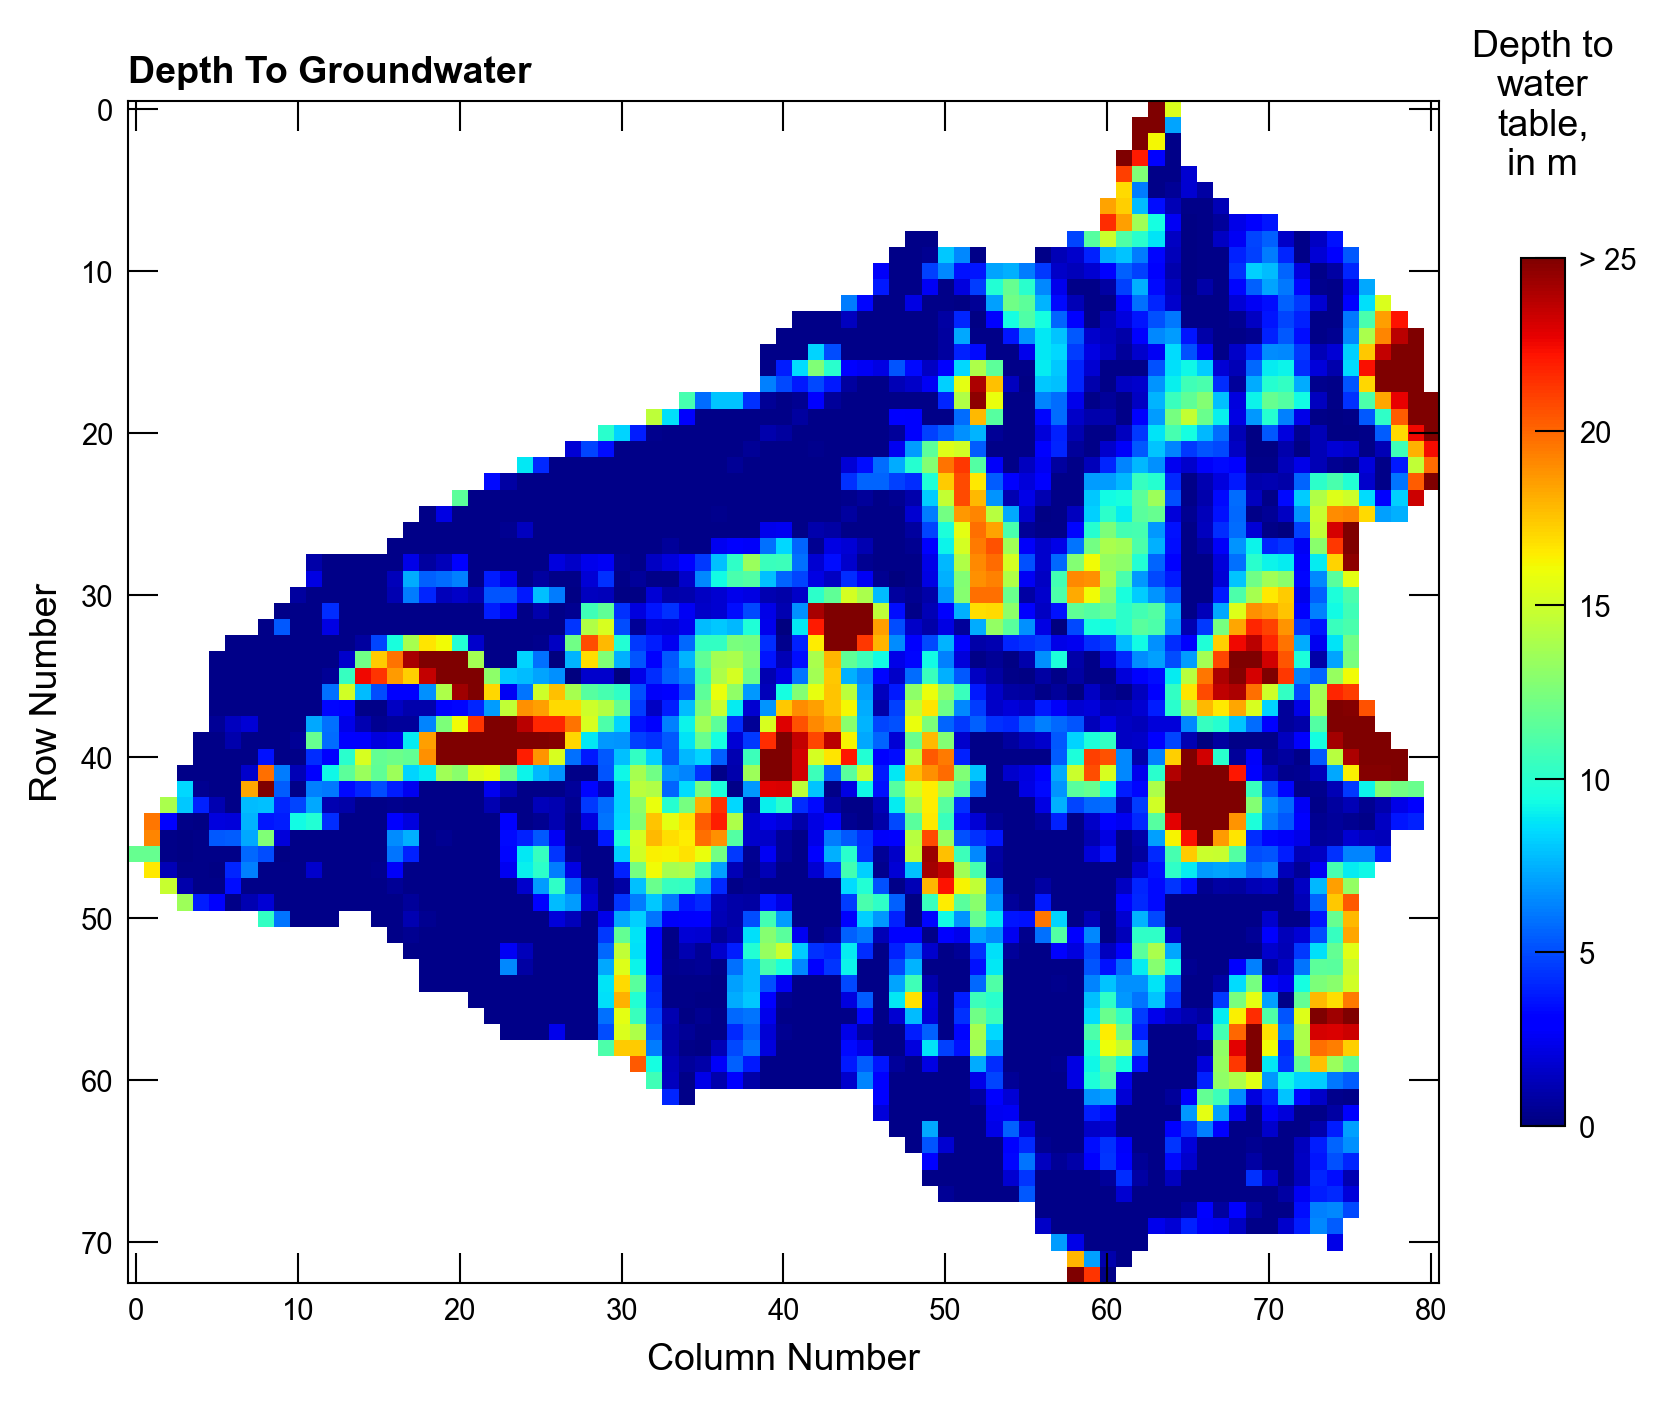

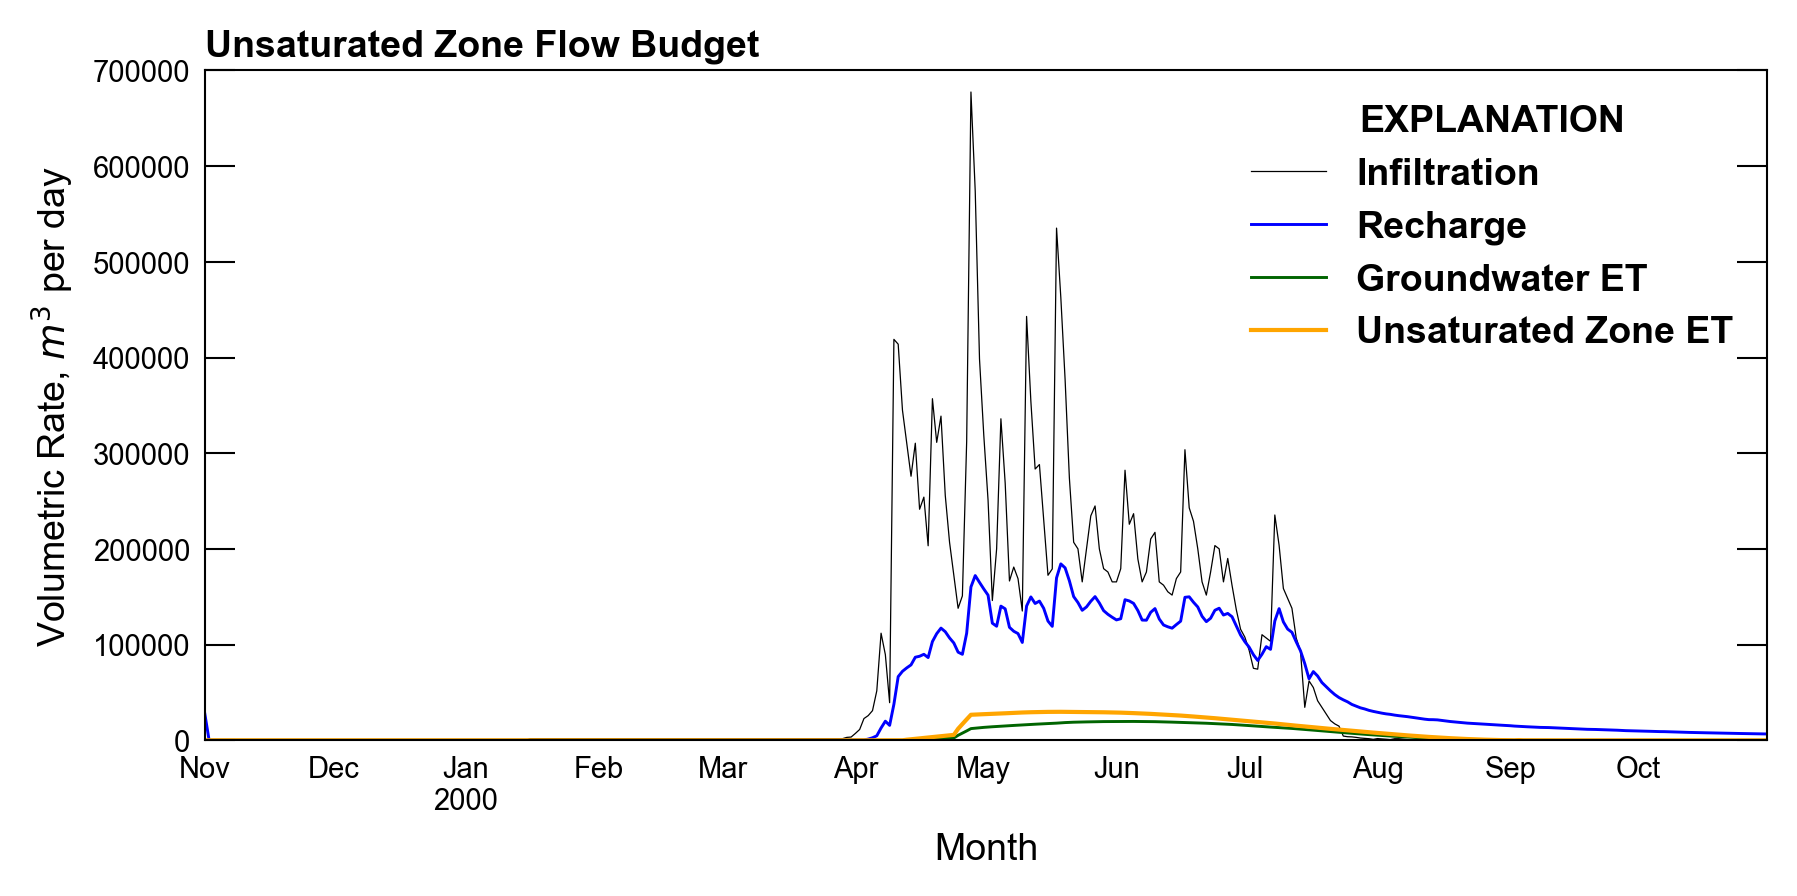

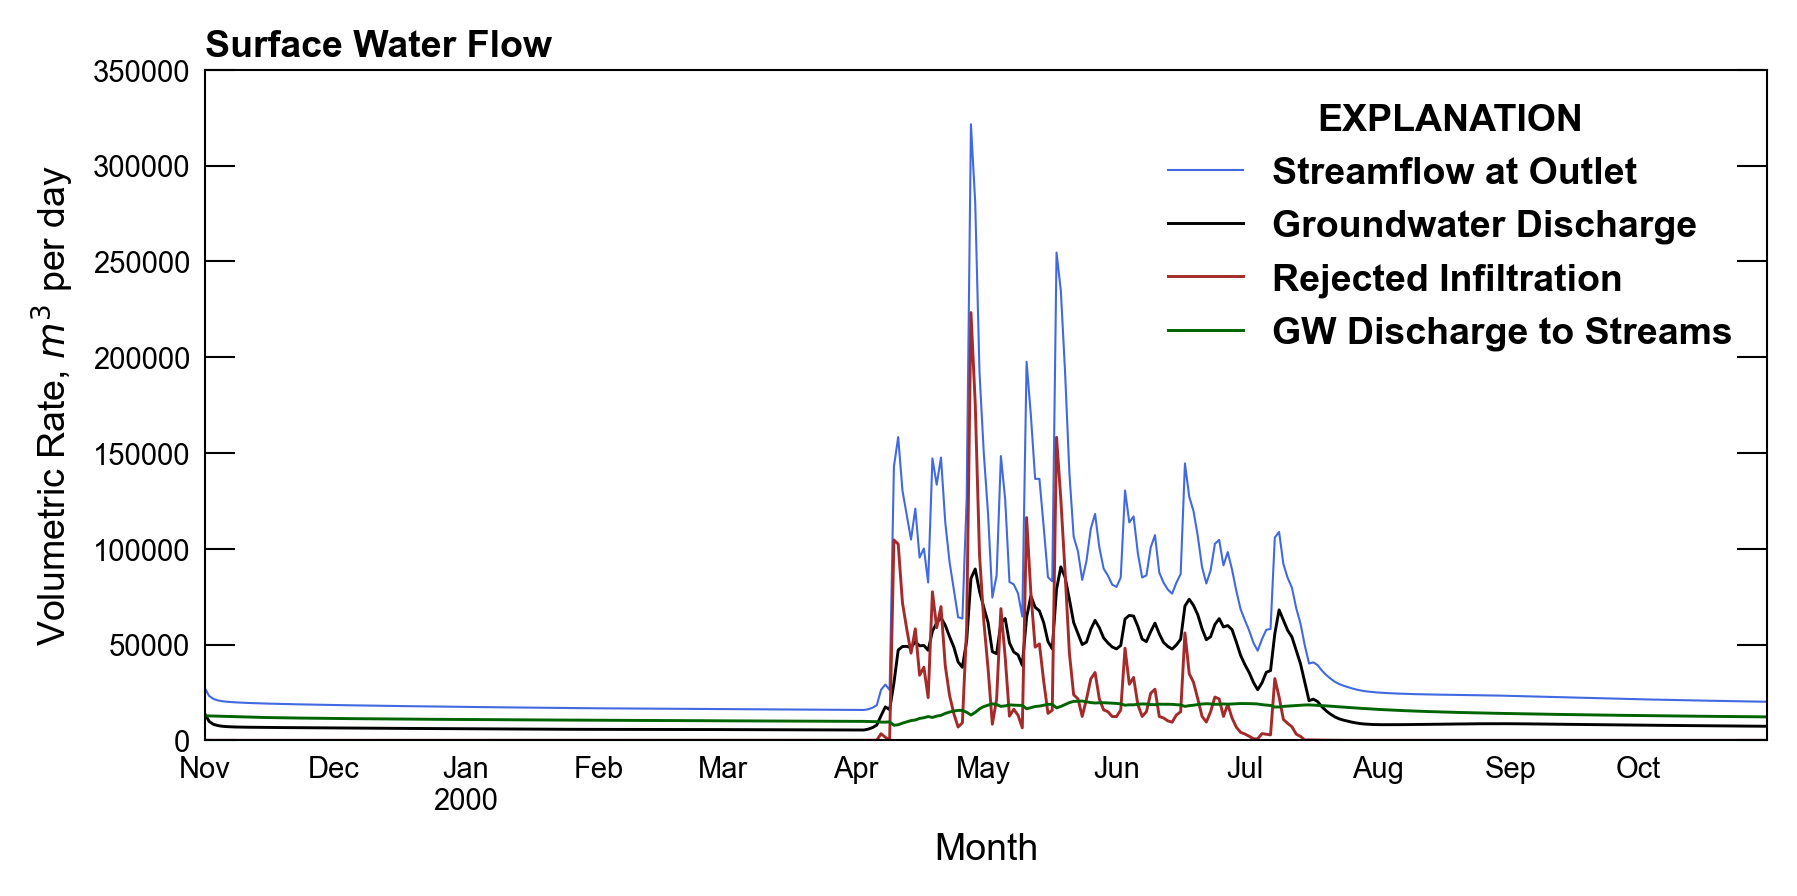

In [5]:
def scenario(silent=True):
    sim = build_models(sim_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim)


scenario()